In [1]:
import models
import datasets
import torch.nn as nn
import torch
from tqdm import tqdm
import torchvision
from torch.utils.data import DataLoader
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
# test_dataset = datasets.helen_data.Helen()

/home/zelin/anaconda3/envs/GFPGAN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
net = models.layers.PCRCN().cuda()
net.load_state_dict(torch.load('/home/zelin/csrnet/Baseline/PCRCN/checkpoints/rcnet_100000.pt'))

<All keys matched successfully>

In [3]:
from glob import glob
from PIL import Image
import torchvision
net.eval()
for path in glob('/home/zelin/csrnet/Dataset/CelebA/*'):
    hr = Image.open(path)
    lr = hr.resize((24,24),Image.BILINEAR)#.resize((192,192),Image.BILINEAR)
    lr = torchvision.transforms.ToTensor()(lr).float().cuda()
    with torch.no_grad():
        _2x_sr,_4x_sr,_8x_sr,_4x_par,_8x_par = net(lr.unsqueeze(0))
        torchvision.utils.save_image(_8x_sr[-1],'results/celeba/%s'%path.split('/')[-1].replace('jpg','png'))

In [4]:
from glob import glob
from PIL import Image
import torchvision
net.eval()
for path in glob('/home/zelin/csrnet/Dataset/helen/*'):
    hr = Image.open(path)
    lr = hr.resize((24,24),Image.BILINEAR)#.resize((192,192),Image.BILINEAR)
    lr = torchvision.transforms.ToTensor()(lr).float().cuda()
    with torch.no_grad():
        _2x_sr,_4x_sr,_8x_sr,_4x_par,_8x_par = net(lr.unsqueeze(0))
        torchvision.utils.save_image(_8x_sr[-1],'results/helen/%s'%path.split('/')[-1].replace('jpg','png'))

In [4]:
from glob import glob
from PIL import Image
import torchvision
net.eval()
for path in glob('/home/zelin/csrnet/Dataset/helen/*'):
    hr = Image.open(path)
    lr = hr.resize((24,24),Image.BILINEAR).resize((192,192),Image.BILINEAR)
    lr = torchvision.transforms.ToTensor()(lr).float().cuda()
    with torch.no_grad():
        coarse_sr,refine_sr,lds = net(lr.unsqueeze(0))
        torchvision.utils.save_image(coarse_sr[-1],'results/helen_/%s'%path.split('/')[-1])

In [4]:
psnr = 0
for j,test_ in enumerate(test_data):
    net.eval()
    lr,hr = test_
    lr = lr.float().cuda()
    hr = hr.float().cuda()
    with torch.no_grad():
        coarse_sr,refine_sr,lds = net(lr)
        mse = ((refine_sr[-1]-hr)**2).mean(dim=[1,2,3])
        psnr += (10*torch.log10(1/mse)).mean()
    torchvision.utils.save_image(refine_sr[-1],

In [5]:
import cv2
import numpy as np
import math
def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(img1.shape[2]):
                ssims.append(ssim(img1[..., i], img2[..., i]))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

def bgr2ycbcr(img, only_y=True):
    '''same as matlab rgb2ycbcr
    only_y: only return Y channel
    Input:
        uint8, [0, 255]
        float, [0, 1]
    '''
    in_img_type = img.dtype
    img.astype(np.float32)
    if in_img_type != np.uint8:
        img *= 255.
    # convert
    if only_y:
        rlt = np.dot(img, [24.966, 128.553, 65.481]) / 255.0 + 16.0
    else:
        rlt = np.matmul(img, [[24.966, 112.0, -18.214], [128.553, -74.203, -93.786],
                              [65.481, -37.797, 112.0]]) / 255.0 + [16, 128, 128]
    if in_img_type == np.uint8:
        rlt = rlt.round()
    else:
        rlt /= 255.
    return rlt.astype(in_img_type)


In [7]:
import numpy as np
psnr_,ssim_,count = 0, 0, 0
for path in glob('/home/zelin/csrnet/Dataset/helen/*'):
    hr = np.array(Image.open(path))
    sr = np.array(Image.open(path.replace('Dataset/helen/','Baseline/RCNet/results/helen_/')))
    hr = bgr2ycbcr(hr)
    sr = bgr2ycbcr(sr)
    ssim_ += calculate_ssim(hr,sr)
    psnr_ += calculate_psnr(hr,sr)
    count += 1

psnr_/count,ssim_/count
    

(26.057283305605388, 0.7424278535132259)

In [6]:
import numpy as np
psnr_,ssim_,count = 0, 0, 0
for path in glob('/home/zelin/csrnet/Dataset/CelebA/*'):
    hr = np.array(Image.open(path))
    sr = np.array(Image.open(path.replace('Dataset/CelebA/','Baseline/PCRCN/results/celeba/').replace('jpg','png')))
    hr = bgr2ycbcr(hr)
    sr = bgr2ycbcr(sr)
    ssim_ += calculate_ssim(hr,sr)
    psnr_ += calculate_psnr(hr,sr)
    count += 1

psnr_/count,ssim_/count
    

(25.9445228456304, 0.7257981522536174)

In [8]:
import numpy as np
psnr_,ssim_,count = 0, 0, 0
for path in glob('/home/zelin/csrnet/Dataset/helen/*'):
    hr = np.array(Image.open(path))
    sr = np.array(Image.open(path.replace('Dataset/helen/','Baseline/PCRCN/results/helen/').replace('jpg','png')))
    hr = bgr2ycbcr(hr)
    sr = bgr2ycbcr(sr)
    ssim_ += calculate_ssim(hr,sr)
    psnr_ += calculate_psnr(hr,sr)
    count += 1

psnr_/count,ssim_/count
    

(26.79992016299421, 0.7585182943301344)

In [14]:
import numpy as np
psnr_,ssim_,count = 0, 0, 0
for path in glob('/home/zelin/csrnet/Dataset/CelebA/*'):
    hr = np.array(Image.open(path))
    sr = np.array(Image.open(path.replace('Dataset/CelebA/','Baseline/DIC/CelebA/').replace('jpg','png')))
    hr = bgr2ycbcr(hr)
    sr = bgr2ycbcr(sr)
    ssim_ += calculate_ssim(hr,sr)
    psnr_ += calculate_psnr(hr,sr)
    count += 1

psnr_/count,ssim_/count
    

(26.676860147116624, 0.7539169609456831)

In [12]:
import numpy as np
psnr_,ssim_,count = 0, 0, 0
for path in glob('/home/zelin/csrnet/Dataset/helen/*'):
    hr = np.array(Image.open(path))
    sr = np.array(Image.open(path.replace('Dataset/helen/','Baseline/DIC/helen/')))
    hr = bgr2ycbcr(hr)
    sr = bgr2ycbcr(sr)
    ssim_ += calculate_ssim(hr,sr)
    psnr_ += calculate_psnr(hr,sr)
    count += 1

psnr_/count,ssim_/count
    

(27.557422923514604, 0.7843339788199409)

In [16]:
import numpy as np
psnr_,ssim_,count = 0, 0, 0
for path in glob('/home/zelin/csrnet/Dataset/helen/*'):
    hr = np.array(Image.open(path))
    sr = np.array(Image.open(path.replace('Dataset/helen/','Baseline/DIC/helen_origin/')))
    hr = bgr2ycbcr(hr)
    sr = bgr2ycbcr(sr)
    ssim_ += calculate_ssim(hr,sr)
    psnr_ += calculate_psnr(hr,sr)
    count += 1

psnr_/count,ssim_/count
    

(27.46131209914116, 0.7790349586460384)

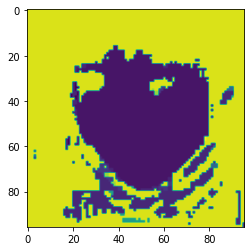

In [30]:
from matplotlib import pyplot as plt
plt.imshow(_8x_par[0][0].argmax(0).detach().cpu().numpy())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


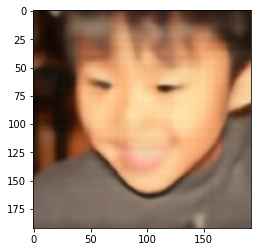

In [31]:
plt.imshow(_8x_sr[-1][0].permute(1,2,0).detach().cpu().numpy())

In [29]:
_8x_par[0][0].argmax(0).cpu().numpy()

array([[17, 17, 17, ..., 17, 17, 17],
       [17, 17, 17, ..., 17, 17, 17],
       [17, 17, 17, ..., 17, 17, 17],
       ...,
       [17, 17, 17, ...,  2, 17, 17],
       [17, 17, 17, ...,  2, 17,  2],
       [17, 17, 17, ..., 17, 17,  2]])